In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
import io

# Question 0 - RECS and Replicate Weights

2009 CSV File Data : <https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv>

2009 Replicate Weights: <https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public_repweights.csv>

2015 CSV File Data : <https://www.eia.gov/consumption/residential/data/2015/csv/recs2015_public_v4.csv>

The data correspons to the Residential Energy Consumption Survey (RECS) conducted by the U.S. Department of Energy

In [2]:
#Columns to be used

cols_without_brrwt = ["DOEID","REGIONC","NWEIGHT","HDD65","CDD65"]
cols_names = ["id", "census region", "sample weight",
              "heating degree days", "cooling degree days"]
regions_names = ["NorthEast", "MidWest", "South", "West"]

Using the [2015 microdata file to compute estimates and standard error (RSEs)][1] as a reference we apply the Fay's method of the balanced repeated replication(BRR) technique. In this method, several replicate weights subsample are used to calculate the point estimate of the statictic to calculate. Then, the differences between the point estimate from the full sample and the ones from the replicated subsamples are used to calculate the standar error of the statistic.

The equation to calculate the variance of the statistic of interest, $\theta$, is the following:
$$
\mathrm{Var}(\hat{\theta}) = \frac{1}{R(1-\epsilon)^2}\sum_{r=1}^{R}(\hat{\theta_r} - \hat{\theta})^2,
$$

where $\hat{\theta}$ is the point estimate of the full sample, $R$ is the number of replicate subsamples, $\hat{\theta_r}$ the point estimate of the r-th replicate subsample and $\epsilon$ the Fay coefficient. In this case $\epsilon = 0.5$

[1]:https://www.eia.gov/consumption/residential/data/2015/pdf/microdata_v3.pdf


# Question 1 -  Data preparation

In [3]:
link_2015 = 'https://www.eia.gov/consumption/residential/data/2015/csv/recs2015_public_v4.csv'
link_2009 = 'https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv'
link_2009_BRRWT = "https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public_repweights.csv"

file_2015 = "./recs2015_public_v4.csv"
file_2009 = "./recs2009_public.csv"
file_2009_BRRWT = "./recs2009_public_repweights.csv"


#Checking if file exist in local foulder or it needs to download it.
if os.path.exists(file_2009):
    df_2009=pd.read_csv(file_2009, usecols=cols_without_brrwt)
    print("File with 2009's data was found in local directory.")
else:
    df_2009=pd.read_csv(link_2009, names=cols_names, usecols=cols_without_brrwt)
    print("File with 2009's data was not present in local directory, so it was downloaded from URL.")

if os.path.exists(file_2009_BRRWT):
    df_2009_brrwt=pd.read_csv(file_2009_BRRWT).filter(regex="brr")
    print("File with 2009's replicate weights data was found in local directory.")
else:
    df_2009_brrwt=pd.read_csv(link_2009_BRRWT).filter(regex="brr")
    print("File with 2009's replicate weights data was not present in local directory, so it was downloaded from URL.")    
    
    
if os.path.exists(file_2015):
    df_2015=pd.read_csv(file_2015, usecols=cols_without_brrwt)
    df_2015_brrwt=pd.read_csv(file_2015).filter(regex="BRRWT")
    print("File with 2015's data was found in local directory.")
else:
    df_2015=pd.read_csv(link_2015, usecols=cols_without_brrwt)
    df_2015_brrwt=pd.read_csv(link_2015).filter(regex="BRRWT")
    print("File with 2015's data was not present in local directory, so it was downloaded from URL.")

    
#Saving dataframes to local directory    
pd.concat([df_2015,df_2015_brrwt],axis=1).to_csv(file_2015)
df_2009.to_csv(file_2009)
df_2009_brrwt.to_csv(file_2009_BRRWT)


dtypes = [int, pd.CategoricalDtype([1,2,3,4]), float, int, int]
rename_cols = dict(zip(cols_without_brrwt, cols_names))
dtype_cols = dict(zip(cols_without_brrwt, dtypes))
df_2009 = df_2009.astype(dtype_cols, copy=False)
df_2015 = df_2015.astype(dtype_cols, copy=False)
df_2009.rename(columns=rename_cols, inplace=True)
df_2015.rename(columns=rename_cols, inplace=True)
#df_2009_brrwt.insert(0, 'census region', df_2009['census region'])
#df_2015_brrwt.insert(0, 'census region', df_2015['census region'])

df_2009_brrwt.insert(0, 'census region', df_2009['census region'])
df_2015_brrwt.insert(0, 'census region', df_2015['census region'])
    

File with 2009's data was found in local directory.
File with 2009's replicate weights data was found in local directory.
File with 2015's data was found in local directory.


### Q2 - part a)

In [4]:
#Calculate heating degree days and cooling degree days by Census Region.
heat_09 = df_2009.groupby(['census region']).apply(lambda x: np.average(x['heating degree days'],
                                                              weights=x['sample weight']))
cool_09 = df_2009.groupby(['census region']).apply(lambda x: np.average(x['cooling degree days'],
                                                              weights=x['sample weight']))
heat_15 = df_2015.groupby(['census region']).apply(lambda x: np.average(x['heating degree days'],
                                                              weights=x['sample weight']))
cool_15 = df_2015.groupby(['census region']).apply(lambda x: np.average(x['cooling degree days'],
                                                              weights=x['sample weight']))

point_est = pd.DataFrame({"heat ddays 2009":heat_09,   
                          "cool ddays 2009":cool_09,
                          "heat ddays 2015":heat_15,
                          "cool ddays 2015":cool_15,
                               })

point_est.reset_index(inplace=True)

### Q1 - part b)

In [5]:
long_09 = df_2009_brrwt.melt(id_vars=["census region"], 
                             value_vars=["brr_weight_"+str(i) for i in range(1,df_2009_brrwt.shape[1]-1)])

long_15 = df_2015_brrwt.melt(id_vars=["census region"], 
                             value_vars=["BRRWT"+str(i) for i in range(1,df_2015_brrwt.shape[1]-1)])

# Question 2 - Construct and report the estimates

In [6]:
bwrrt_09 = df_2009_brrwt.T
bwrrt_15 = df_2015_brrwt.T

#bwrrt_09.reset_index(inplace=True)
#bwrrt_15.reset_index(inplace=True)

In [7]:
mask1_09 = (df_2009['census region']==1).values
mask2_09 = (df_2009['census region']==2).values
mask3_09 = (df_2009['census region']==3).values
mask4_09 = (df_2009['census region']==4).values 

In [8]:
heat_cat3_09 = bwrrt_09.apply(lambda x: np.average(df_2009[mask1_09]['heating degree days'],
                                       weights=x.iloc[mask1_09]),axis=1)

In [9]:
#Calculates the point estimate using the replicated weights for each year and Census region.

mask1_09 = (df_2009['census region']==1).values
mask2_09 = (df_2009['census region']==2).values
mask3_09 = (df_2009['census region']==3).values
mask4_09 = (df_2009['census region']==4).values 

mask1_15 = (df_2015['census region']==1).values
mask2_15 = (df_2015['census region']==2).values 
mask3_15 = (df_2015['census region']==3).values 
mask4_15 = (df_2015['census region']==4).values


heat_cat1_09 = bwrrt_09.apply(lambda x: np.average(df_2009[mask1_09]['heating degree days'],weights=x.iloc[mask1_09]),axis=1)
heat_cat2_09 = bwrrt_09.apply(lambda x: np.average(df_2009[mask2_09]['heating degree days'],
                                       weights=x.iloc[mask2_09]),axis=1)
heat_cat3_09 = bwrrt_09.apply(lambda x: np.average(df_2009[mask3_09]['heating degree days'],
                                       weights=x.iloc[mask3_09]),axis=1)
heat_cat4_09 = bwrrt_09.apply(lambda x: np.average(df_2009[mask4_09]['heating degree days'],
                                       weights=x.iloc[mask4_09]),axis=1)

cool_cat1_09 = bwrrt_09.apply(lambda x: np.average(df_2009[mask1_09]['cooling degree days'],
                                       weights=x.iloc[mask1_09]),axis=1)
cool_cat2_09 = bwrrt_09.apply(lambda x: np.average(df_2009[mask2_09]['cooling degree days'],
                                       weights=x.iloc[mask2_09]),axis=1)
cool_cat3_09 = bwrrt_09.apply(lambda x: np.average(df_2009[mask3_09]['cooling degree days'],
                                       weights=x.iloc[mask3_09]),axis=1)
cool_cat4_09 = bwrrt_09.apply(lambda x: np.average(df_2009[mask4_09]['cooling degree days'],
                                       weights=x.iloc[mask4_09]),axis=1)

bwrrt_09 = bwrrt_09.assign(heat_ddays_cat1=heat_cat1_09,
                         heat_ddays_cat2=heat_cat2_09,
                         heat_ddays_cat3=heat_cat3_09,
                         heat_ddays_cat4=heat_cat4_09,
                         cool_ddays_cat1=cool_cat1_09,
                         cool_ddays_cat2=cool_cat2_09,
                         cool_ddays_cat3=cool_cat3_09,
                         cool_ddays_cat4=cool_cat4_09,)


heat_cat1_15 = bwrrt_15.apply(lambda x: np.average(df_2015[mask1_15]['heating degree days'],
                                       weights=x.iloc[mask1_15]),axis=1)
heat_cat2_15 = bwrrt_15.apply(lambda x: np.average(df_2015[mask2_15]['heating degree days'],
                                       weights=x.iloc[mask2_15]),axis=1)
heat_cat3_15 = bwrrt_15.apply(lambda x: np.average(df_2015[mask3_15]['heating degree days'],
                                       weights=x.iloc[mask3_15]),axis=1)
heat_cat4_15 = bwrrt_15.apply(lambda x: np.average(df_2015[mask4_15]['heating degree days'],
                                       weights=x.iloc[mask4_15]),axis=1)

cool_cat1_15 = bwrrt_15.apply(lambda x: np.average(df_2015[mask1_15]['cooling degree days'],
                                       weights=x.iloc[mask1_15]),axis=1)
cool_cat2_15 = bwrrt_15.apply(lambda x: np.average(df_2015[mask2_15]['cooling degree days'],
                                       weights=x.iloc[mask2_15]),axis=1)
cool_cat3_15 = bwrrt_15.apply(lambda x: np.average(df_2015[mask3_15]['cooling degree days'],
                                       weights=x.iloc[mask3_15]),axis=1)
cool_cat4_15 = bwrrt_15.apply(lambda x: np.average(df_2015[mask4_15]['cooling degree days'],
                                       weights=x.iloc[mask4_15]),axis=1)

bwrrt_15 = bwrrt_15.assign(heat_ddays_cat1=heat_cat1_15,
                         heat_ddays_cat2=heat_cat2_15,
                         heat_ddays_cat3=heat_cat3_15,
                         heat_ddays_cat4=heat_cat4_15,
                         cool_ddays_cat1=cool_cat1_15,
                         cool_ddays_cat2=cool_cat2_15,
                         cool_ddays_cat3=cool_cat3_15,
                         cool_ddays_cat4=cool_cat4_15,)


In [10]:
def calculate_variance(df=df_2009, df_brrw=bwrrt_09, cat=1, variable="heat"):
    """
    Parameters:
    ----------
    df: Dataframe with the actual data about heating and cooling degree days with full sample weights.
    df_brrw: Datframe with the calculated heating and cooling days with the replicate weights.
    cat: Category of Census Region in int.
    variable: "heat" or "cool"
    Return:
    ------
    Returns the variance using the Fay's method over the RECS with an Fay coefficient, epsilon=0.5.
    """
    point_est = df.groupby(['census region']).apply(lambda x: np.average(x['heating degree days'],
                                                              weights=x['sample weight']))[cat]
    R = df_brrw.shape[0]-1
    epsilon = 0.5
    variance = np.sum((point_est-df_brrw[variable+"_ddays_cat"+str(cat)])**2)/(R*(1-epsilon)**2)
    return variance


point_est["variance heat 2009"] = \
point_est.apply(lambda x: calculate_variance(df_2009, bwrrt_09, x['census region'], "heat"), axis=1)
point_est["variance cool 2009"] = \
point_est.apply(lambda x: calculate_variance(df_2009, bwrrt_09, x['census region'], "cool"), axis=1)

point_est["variance heat 2015"] = \
point_est.apply(lambda x: calculate_variance(df_2015, bwrrt_15, x['census region'], "heat"), axis=1)
point_est["variance cool 2015"] = \
point_est.apply(lambda x: calculate_variance(df_2015, bwrrt_15, x['census region'], "cool"), axis=1)

In [11]:
def compute_statistics(x,Var=0,CI=0.95,
                       formt="{0:.3f} [{1:.0f}% CI: ({2:.2f} , {3:.2f})]"):
    """
    Calculates a point estimates and a confidence interval assuming a gaussian distribution.
    Parameters:
    ----------
        x = Point estimate of the statistic.
        Var = Variance 
        CI = Confidence interval
        formt = Format of output.
    Returns:
    -------
        String with point estimate and confidence interval or 
        Dictionary with keys "est","lwr","upr","level" if formt is None.
    """
    std = np.sqrt(Var)
    z = (1+CI)/2.
    up = x + norm.ppf(q=z)*std
    lw = x + norm.ppf(q=1-z)*std
    line = formt.format(x, 100*CI, lw, up)
    if formt==None:
        output = {}
        output["est"] = x
        output["lwr"] = lw
        output["upr"] = up
        output["level"] = CI
        return output
    return line


point_est["CI heating ddays 09' "] = point_est.apply(lambda y: compute_statistics(x=y['heat ddays 2009'],
                                                                                  Var=y['variance heat 2009']),
                                                     axis=1)

point_est["CI cooling ddays 09' "] = point_est.apply(lambda y: compute_statistics(x=y['cool ddays 2009'],
                                                                                  Var=y['variance cool 2009']),
                                                     axis=1)

point_est["CI heating ddays 15' "] = point_est.apply(lambda y: compute_statistics(x=y['heat ddays 2015'],
                                                                                  Var=y['variance heat 2015']),
                                                     axis=1)

point_est["CI cooling ddays 15' "] = point_est.apply(lambda y: compute_statistics(x=y['cool ddays 2015'],
                                                                                  Var=y['variance cool 2015']),
                                                     axis=1)


In [12]:
point_est.loc[:,["CI heating ddays 09' ","CI cooling ddays 09' ",
                 "CI heating ddays 15' ","CI cooling ddays 15' "]]

,CI heating ddays 09',CI cooling ddays 09',CI heating ddays 15',CI cooling ddays 15'
0,"5700.988 [95% CI: (5616.84 , 5785.14)]","680.715 [95% CI: (-19038.88 , 20400.31)]","5695.673 [95% CI: (5528.61 , 5862.73)]","983.920 [95% CI: (-17593.83 , 19561.67)]"
1,"6325.337 [95% CI: (6233.22 , 6417.45)]","660.888 [95% CI: (-21587.98 , 22909.76)]","5785.490 [95% CI: (5632.73 , 5938.25)]","956.074 [95% CI: (-18074.42 , 19986.57)]"
2,"2696.668 [95% CI: (2592.72 , 2800.61)]","2207.728 [95% CI: (284.82 , 4130.63)]","2211.880 [95% CI: (2056.15 , 2367.61)]","2639.851 [95% CI: (950.82 , 4328.88)]"
3,"3259.641 [95% CI: (3085.72 , 3433.56)]","1328.642 [95% CI: (-6258.88 , 8916.17)]","2814.831 [95% CI: (2624.34 , 3005.32)]","1576.774 [95% CI: (-3305.87 , 6459.42)]"


### Q2 part b)

In [13]:
#Calculates the variance of the difference between point estimates.

point_est["Variance difference heat 15' - 09'"] = point_est["variance heat 2009"] \
+ point_est["variance heat 2015"]
point_est["Variance difference cool 15' - 09'"] = point_est["variance cool 2009"] \
+ point_est["variance cool 2015"]


#Calculates the difference between point estimates.
point_est["Estimate difference heat 15' - 09'"] = point_est["heat ddays 2015"]-point_est["heat ddays 2009"]
point_est["Estimate difference cool 15' - 09'"] = point_est["cool ddays 2015"]-point_est["cool ddays 2009"]



#Calculates the confidence interval of the difference between point estimates.

point_est["CI difference heat 15'-09' "] = \
point_est.apply(lambda y: compute_statistics(x=y["Estimate difference heat 15' - 09'"], 
                                             Var=y["Variance difference heat 15' - 09'"]), 
                axis=1)

point_est["CI difference cool 15'-09' "] = \
point_est.apply(lambda y: compute_statistics(x=y["Estimate difference cool 15' - 09'"],
                                             Var=y["Variance difference cool 15' - 09'"]),
                axis=1)


In [14]:
point_est.loc[:,["census region","CI difference heat 15'-09' ","CI difference cool 15'-09' "]]

,census region,CI difference heat 15'-09',CI difference cool 15'-09'
0,1,"-5.315 [95% CI: (-192.37 , 181.74)]","303.205 [95% CI: (-26789.14 , 27395.55)]"
1,2,"-539.847 [95% CI: (-718.23 , -361.46)]","295.186 [95% CI: (-28982.32 , 29572.69)]"
2,3,"-484.788 [95% CI: (-672.02 , -297.55)]","432.123 [95% CI: (-2127.25 , 2991.50)]"
3,4,"-444.811 [95% CI: (-702.75 , -186.87)]","248.132 [95% CI: (-8774.66 , 9270.92)]"


# Question 3

In [15]:
plt.style.use(['seaborn-white'])

plt.rc('xtick', labelsize=11) 
plt.rc('ytick', labelsize=11) 

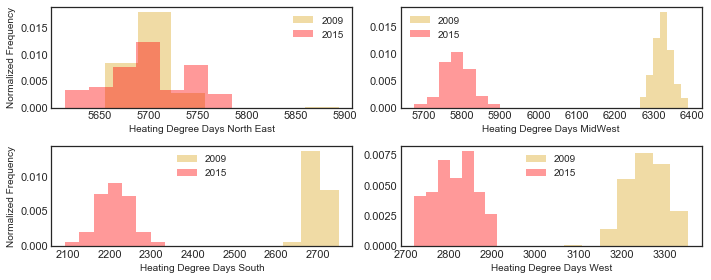

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10,4))
                    
axs[0,0].hist(bwrrt_09['heat_ddays_cat1'], color='goldenrod', label="2009",
              alpha=0.4, density=True, bins=7)
axs[0,0].hist(bwrrt_15['heat_ddays_cat1'], color='r', label="2015",
              alpha=0.4, density=True, bins=7)
axs[0,0].set_xlabel('Heating Degree Days North East')
axs[0,0].legend()
axs[0,0].set_ylabel("Normalized Frequency")


axs[0,1].hist(bwrrt_09['heat_ddays_cat2'], color='goldenrod', label="2009",
              alpha=0.4, density=True, bins=7)
axs[0,1].hist(bwrrt_15['heat_ddays_cat2'], color='r', label="2015",
              alpha=0.4, density=True, bins=7)
axs[0,1].set_xlabel('Heating Degree Days MidWest')
axs[0,1].legend()


axs[1,0].hist(bwrrt_09['heat_ddays_cat3'], color='goldenrod', label="2009",
              alpha=0.4, density=True, bins=7)
axs[1,0].hist(bwrrt_15['heat_ddays_cat3'], color='r', label="2015",
              alpha=0.4, density=True, bins=7)
axs[1,0].set_xlabel('Heating Degree Days South')
axs[1,0].legend(loc=9)
axs[1,0].set_ylabel("Normalized Frequency")


axs[1,1].hist(bwrrt_09['heat_ddays_cat4'], color='goldenrod', label="2009",
              alpha=0.4, density=True, bins=7)
axs[1,1].hist(bwrrt_15['heat_ddays_cat4'], color='r', label="2015",
              alpha=0.4, density=True, bins=7)
axs[1,1].set_xlabel('Heating Degree Days West')
axs[1,1].legend(loc=9)



plt.tight_layout()

**Figure 1**: Histogram of the heating degree days of 2009 and 2015 using the replicated weights for each Census region.

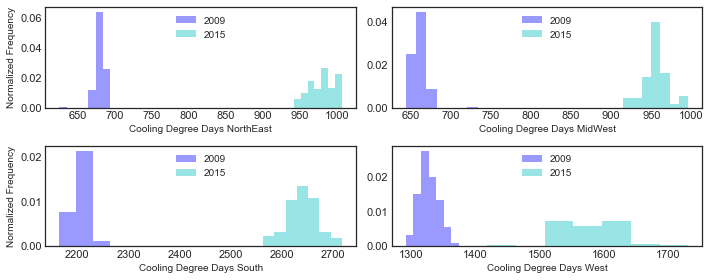

In [17]:
fig, axs = plt.subplots(2, 2,figsize=(10,4))
                    
axs[0,0].hist(bwrrt_09['cool_ddays_cat1'], color='b', label="2009",
              alpha=0.4, density=True, bins=7)
axs[0,0].hist(bwrrt_15['cool_ddays_cat1'], color='c', label="2015",
              alpha=0.4, density=True, bins=7)
axs[0,0].set_xlabel('Cooling Degree Days NorthEast')
axs[0,0].legend(loc=9)
axs[0,0].set_ylabel("Normalized Frequency")


axs[0,1].hist(bwrrt_09['cool_ddays_cat2'], color='b', label="2009",
              alpha=0.4, density=True, bins=7)
axs[0,1].hist(bwrrt_15['cool_ddays_cat2'], color='c', label="2015",
              alpha=0.4, density=True, bins=7)
axs[0,1].set_xlabel('Cooling Degree Days MidWest')
axs[0,1].legend(loc=9)


axs[1,0].hist(bwrrt_09['cool_ddays_cat3'], color='b', label="2009",
              alpha=0.4, density=True, bins=7)
axs[1,0].hist(bwrrt_15['cool_ddays_cat3'], color='c', label="2015",
              alpha=0.4, density=True, bins=7)
axs[1,0].set_xlabel('Cooling Degree Days South')
axs[1,0].legend(loc=9)
axs[1,0].set_ylabel("Normalized Frequency")


axs[1,1].hist(bwrrt_09['cool_ddays_cat4'], color='b', label="2009",
              alpha=0.4, density=True, bins=7)
axs[1,1].hist(bwrrt_15['cool_ddays_cat4'], color='c', label="2015",
              alpha=0.4, density=True, bins=7)
axs[1,1].set_xlabel('Cooling Degree Days West')
axs[1,1].legend(loc=9)



plt.tight_layout()

**Figure 2**: Histogram of the cooling degree days of 2009 and 2015 using the replicated weights for each Census region.

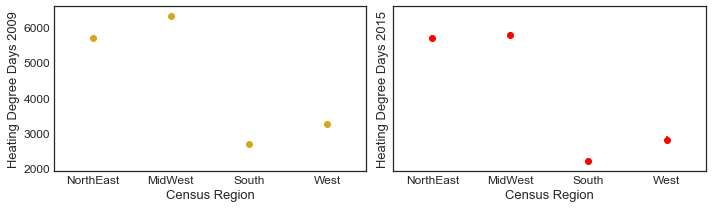

In [18]:
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,3))
                    
axs[0].errorbar(point_est["census region"],
                point_est["heat ddays 2009"],
                np.sqrt(point_est["variance heat 2009"]),
                marker='o', ls="", c="goldenrod", ms=6)

axs[0].set_xlim([0.5,4.5])
axs[0].set_xlabel('Census Region', fontsize=13)
axs[0].set_ylabel('Heating Degree Days 2009', fontsize=13)

axs[1].errorbar(point_est["census region"],
                point_est["heat ddays 2015"],
                np.sqrt(point_est["variance heat 2015"]),
                marker='o', ls="", c="red", ms=6)

axs[1].set_xlim([0.5,4.5])
axs[1].set_xticks([1,2,3,4])
axs[1].set_xticklabels(regions_names)
axs[1].set_xlabel('Census Region', fontsize=13)
axs[1].set_ylabel('Heating Degree Days 2015', fontsize=13)


plt.tight_layout()


**Figure 3**: Heating degree days estimates for 2009 and 2015 for each Census region with 95% confidence intervals using Fay's method of balanced repeated replication.

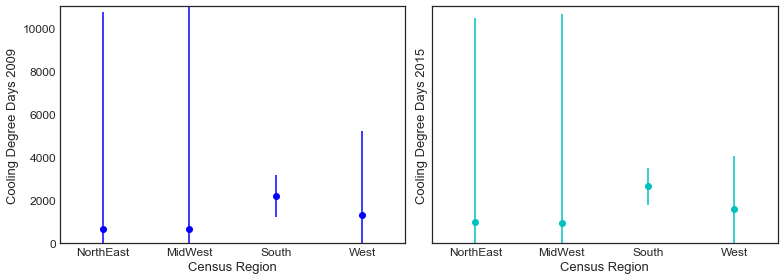

In [19]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11,4))

axs[0].errorbar(point_est["census region"],
                point_est["cool ddays 2009"],
                np.sqrt(point_est["variance cool 2009"]),
                marker='o', ls="", c='b', ms=6)
axs[0].set_ylim(bottom=0)
axs[0].set_xticks([1,2,3,4])
axs[0].set_xlim([0.5,4.5])
axs[0].set_xticklabels(regions_names)
axs[0].set_xlabel('Census Region', fontsize=13)
axs[0].set_ylabel('Cooling Degree Days 2009', fontsize=13)

axs[1].errorbar(point_est["census region"],
                point_est["cool ddays 2015"],
                np.sqrt(point_est["variance cool 2015"]),
                marker='o', ls="", c='c', ms=6)
axs[1].set_ylim(bottom=0, top=11000)
axs[1].set_xticks([1,2,3,4])
axs[1].set_xlim([0.5,4.5])
axs[1].set_xticklabels(regions_names)
axs[1].set_xlabel('Census Region', fontsize=13)
axs[1].set_ylabel('Cooling Degree Days 2015', fontsize=13)


plt.tight_layout()

**Figure 4**: Cooling degree days estimates for 2009 and 2015 for each Census region with 95% confidence intervals using Fay's method of balanced repeated replication.

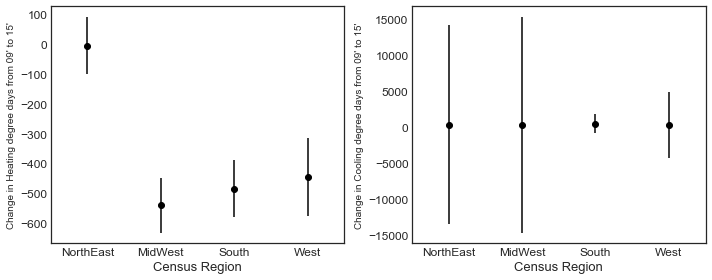

In [20]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10,4))

axs[0].errorbar(point_est["census region"],
                point_est["Estimate difference heat 15' - 09'"],
                np.sqrt(point_est["Variance difference heat 15' - 09'"]),
                marker='o', ls="", c="k", ms=6)
axs[0].set_xticks([1,2,3,4])
axs[0].set_xlim([0.5,4.5])
axs[0].set_xticklabels(regions_names)
axs[0].set_xlabel('Census Region', fontsize=13)
axs[0].set_ylabel('Change in Heating degree days from 09\' to 15\'')

axs[1].errorbar(point_est["census region"],
                point_est["Estimate difference cool 15' - 09'"],
                np.sqrt(point_est["Variance difference cool 15' - 09'"]),
                marker='o', ls="", c="k", ms=6)
axs[1].set_xticks([1,2,3,4])
axs[1].set_xlim([0.5,4.5])
axs[1].set_xticklabels(regions_names)
axs[1].set_xlabel('Census Region', fontsize=13)
axs[1].set_ylabel('Change in Cooling degree days from 09\' to 15\'')


plt.tight_layout()

**Figure 5**: Change of heating and cooling degree days between 2009 and 2015 for each Census region with their respective variance using Fay's method of balanced repeated replication.